# Introduction to pairwise sequence alignment

One of the most fundamental problems in bioinformatics is determining how "similar" a pair of sequences are. There are many applications for this, including determing the function of an unknown gene sequence, determining the source organism of a sequence, developing hypotheses about the relatedness of organisms, or grouping sequences from closely related organisms. On the surface, this seems like a pretty straight-forward problem - not one that would have been at the center of decades of research and the subject of [one of the most cited papers](http://scholar.google.com/citations?view_op=view_citation&hl=en&user=VRccPlQAAAAJ&citation_for_view=VRccPlQAAAAJ:u-x6o8ySG0sC) in modern biology.

For example, imagine you have three sequences - call them ``r1`` (for *reference*) and ``q1`` and ``q2`` (for *query*). Can't you just count the number of differences across their length (i.e., compute the [Hamming distance](http://en.wikipedia.org/wiki/Hamming_distance) between them) to figure out whether ``q1`` or ``q2`` is more closely related to ``r1``? 

In [1]:
%pylab inline
from __future__ import division, print_function

from IPython.core import page
from scipy.spatial.distance import hamming
from skbio import DNA

page.page = print

Populating the interactive namespace from numpy and matplotlib


In [2]:
r1 = DNA("ACCCAGGTTAACGGTGACCAGGTACCAGAAGGGTACCAGGTAGGACACACGGGGATTAA")
q1 = DNA("ACCGAGGTTAACGGTGACCAGGTACCAGAAGGGTACCAGGTAGGAGACACGGCGATTAA")
q2 = DNA("TTCCAGGTAAACGGTGACCAGGTACCAGTTGCGTTTGTTGTAGGAGACACGGGGACCCA")

%psource hamming

def hamming(u, v):
    """
    Computes the Hamming distance between two 1-D arrays.

    The Hamming distance between 1-D arrays `u` and `v`, is simply the
    proportion of disagreeing components in `u` and `v`. If `u` and `v` are
    boolean vectors, the Hamming distance is

    .. math::

       \\frac{c_{01} + c_{10}}{n}

    where :math:`c_{ij}` is the number of occurrences of
    :math:`\\mathtt{u[k]} = i` and :math:`\\mathtt{v[k]} = j` for
    :math:`k < n`.

    Parameters
    ----------
    u : (N,) array_like
        Input array.
    v : (N,) array_like
        Input array.

    Returns
    -------
    hamming : double
        The Hamming distance between vectors `u` and `v`.

    """
    u = _validate_vector(u)
    v = _validate_vector(v)
    return (u != v).mean()



In [3]:
print(hamming(r1, q1))
print(hamming(r1, q2))

0.0508474576271
0.254237288136


In this case, ``q1`` is clearly more similar to ``r1`` than ``q2`` is. But it's not always that simple. Here we're assuming that only substitution events have occurred. Let's define ``q3``, which is the same as ``q1`` except that a single base deletion (with respect to ``r1``) is present toward the beginning of the sequence, and a single base addition at the end of the sequence. (Note: it's required that if we have a deletion we also have an insertion, because ``hamming`` is only defined for sequences of equal length.)

In [4]:
q3 = DNA("ACGAGGTTAACGGTGACCAGGTACCAGAAGGGTACCAGGTAGGAGACACGGCGATTAAA")
print(hamming(r1, q3))

0.661016949153


This one base change had a big effect on the distance between the two sequences. If this is a protein coding sequence, maybe that's reasonable, but given what we know about how biological sequences evolve this doesn't seem biologically justified. In this case, it seems that an insertion or deletion (i.e., an **indel**) event has shifted one sequence relative to the other, which resulted in many of the bases "downstream" of the indel being different. What we'd really want to do is have a way to indicate that an indel seems to have occurred in one of the sequences. For example, let's define ``q4``, where we use a ``-`` character to indicate a deletion with respect to ``r1``. This results in what seems like a more reasonable distance between the two sequences (though given what you know about how indel events can disrupt protein coding sequences, you may feel that this distance is too close to the distance between ``r1`` and ``q1``):

In [5]:
q4 = DNA("AC-GAGGTTAACGGTGACCAGGTACCAGAAGGGTACCAGGTAGGAGACACGGCGATTAA")
print(hamming(r1,q4))

0.0677966101695


What we've done here is create a pairwise alignment of ``r1`` and ``q4``. In other words, we've **aligned** the positions that we hypothesize were derived from the same position in some ancestral sequence. The *alignment* is clear if we print these two sequence out one on top of the other:

In [6]:
print(r1)
print(q4)

ACCCAGGTTAACGGTGACCAGGTACCAGAAGGGTACCAGGTAGGACACACGGGGATTAA
AC-GAGGTTAACGGTGACCAGGTACCAGAAGGGTACCAGGTAGGAGACACGGCGATTAA


Scanning through these two sequences, we can see that they are mostly identicial, with the exception of one ``-`` character, and a few *substitutions* of one base for another. We refer to ``-`` characters in aligned sequences as **gaps**. 

The problem of **pairwise sequence alignment** is, **given two sequences, generate a hypothesis about which bases were derived from a common ancestor**. In other words, align them to one another, inserting gaps as necessary, in a way that maximizes their similarity. Sequence alignment is tricky for reasons including these:
 * Because of insertion/deletion mutations, it's not always clear which bases or amino acid residues are derived from the same common ancestral base or amino acid residue.
 * As sequences get long, there may be many possible ways to align them. We need to figure out which of those alignments is the best hypothesis in light of what we know about the (very messy) underlying biological systems.
 * As sequences are more distantly related, there are fewer identical stretches of bases or amino acid residues, making it harder to determine what the most biologically relevant alignment is.
 * When the sequences get very long, sequence alignment becomes a very computationally expensive problem. We'll come back to this part.

In the next section we'll work through one algorithm for aligning a pair of sequences. As you work through this exercise, try to make a list of the assumptions that we're making that violate what you know about how sequences evolve. 

## A simple procedure for aligning a pair of sequences

Aligning ``seq1`` and ``seq2`` can be achieved algorithmically in a few steps. First, let's define the sequences that we want to align.

In [7]:
seq1 = "ACCGGTGGAACCGGTAACACCCAC"
seq2 = "ACCGGTAACCGGTTAACACCCAC"

I'm going to use a function in the following cells called ``format_matrix`` to display the alignment. Once an object has been imported, you can always view the source code for that function. This will be useful as we begin to explore some of the algorithms that are in use throughout these notebooks. 

For example:

In [8]:
from iab.algorithms import format_matrix

In [9]:
%psource format_matrix

def format_matrix(row_headers, col_headers, data, hide_zeros=False, cell_width=3):
    result = []
    cell_format = "%" + str(cell_width) + "s"
    line_format = cell_format * (len(row_headers) + 1)

    # print a header row
    result.append(line_format % tuple([' '] + list(row_headers)))

    # print the data rows
    for b2, row in zip(col_headers,data):
        if hide_zeros:
            display_row = []
            for v in row:
                if v == 0:
                    display_row.append('')
                else:
                    display_row.append(v)
        else:
            display_row = row
        result.append(line_format % tuple([b2] + display_row))

    return '\n'.join(result)



Now let's look at how to align these sequences.

**Step 1.** Create a matrix, where the columns represent the positions in ``seq1`` and the rows represent the positions in ``seq2``. 

In [10]:
data = []
for p in seq2:
    data.append(['-']*len(seq1))

print(format_matrix(seq1, seq2, data))

     A  C  C  G  G  T  G  G  A  A  C  C  G  G  T  A  A  C  A  C  C  C  A  C
  A  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
  C  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
  C  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
  G  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
  G  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
  T  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
  A  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
  A  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
  C  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
  C  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
  G  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
  G  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -
  T  -  -  -

**Step 2.** Score the cells where the row value is equal to the column value as ``1``, and the others as ``0``. 

In [11]:
data = []
for b2 in seq2:
    row = []
    for b1 in seq1:
        if b1 == b2:
            row.append(1)
        else:
            row.append(0)
    data.append(row)
        
print(format_matrix(seq1, seq2, data, hide_zeros=True))

     A  C  C  G  G  T  G  G  A  A  C  C  G  G  T  A  A  C  A  C  C  C  A  C
  A  1                       1  1                 1  1     1           1   
  C     1  1                       1  1                 1     1  1  1     1
  C     1  1                       1  1                 1     1  1  1     1
  G           1  1     1  1              1  1                              
  G           1  1     1  1              1  1                              
  T                 1                          1                           
  A  1                       1  1                 1  1     1           1   
  A  1                       1  1                 1  1     1           1   
  C     1  1                       1  1                 1     1  1  1     1
  C     1  1                       1  1                 1     1  1  1     1
  G           1  1     1  1              1  1                              
  G           1  1     1  1              1  1                              
  T         

**Step 3**: Identify the “high-scoring” or contiguous diagonals. You can score each diagonal by summing the values in each cell.

In [12]:
line_format = "%3s" * (len(seq1) + 1)
scored_data = []
for i, drow in enumerate(data):
    row = []
    for j, value in enumerate(drow):
        if value > 0:
            if i == 0 or j == 0:
                row.append(value)
            else:
                row.append(value + scored_data[i-1][j-1])
        else:
            row.append(0)
    scored_data.append(row)
        
print(format_matrix(seq1, seq2, scored_data, hide_zeros=True))

     A  C  C  G  G  T  G  G  A  A  C  C  G  G  T  A  A  C  A  C  C  C  A  C
  A  1                       1  1                 1  1     1           1   
  C     2  1                       2  1                 2     2  1  1     2
  C     1  3                       1  3                 1     1  3  2     1
  G           4  1     1  1              4  1                              
  G           1  5     1  2              1  5                              
  T                 6                          6                           
  A  1                       1  1                 7  1     1           1   
  A  1                       1  2                 1  8     1           1   
  C     2  1                       3  1                 9     2  1  1     2
  C     1  3                       1  4                 1     1  3  2     1
  G           4  1     1  1              5  1                              
  G           1  5     1  2              1  6                              
  T         

**Step 4**: Transcribe and score alignments including gaps (subtract one for every non-diagonal cell).

You can now identify the highest scoring contiguous alignments – but notice that this only represents a portion of the full sequences, and there are other regions that are apparently homologous (as evidenced by high alignment scores).

To transcribe a gapped alignment, add a gap character in the first (horizontal) sequence for each vertical line in the matrix, and a gap character in the second (vertical) sequence for each horizontal line in the matrix.

``ACCGGTGGAACCGG-TAACACCCAC``

``ACCGGT--AACCGGTTAACACCCAC``

Alignment score: 19


``ACCGGTGGAACCGGTAACACCCAC``

``ACCGGT--------TAACACCCAC``

Alignment score: 8

**Remember that an alignment represents a hypothesis about the evolutionary history of a sequence.  Which of these hypotheses do you think is more likely to be true based on what you know about sequence evolution?**

**As an exercise**, scroll back to where we defined `seq1` and `seq2` and redefine one or both of those as other sequences. Execute that cell, and the one up to the previous cell, and transcribe the highest scoring alignment. 

**Complexities**: why this simple procedure is too simple

1. We’re scoring all matches as 1 and all mismatches as 0. This suggests that all substitutions are treated equally. What’s a more biologically meaningful way to do this (e.g., in protein alignments)?

2. Similarly, every gap that is introduced results in the same penalty being incurred. Based on what we know about how insertion/deletion events occur, it likely makes more sense to score *opening a new gap* differently from *extending an existing gap*.

3. When searching a novel sequence against a database, you may have billions of bases to search against (which would correspond to billions of columns in these matrices). How can this be done efficiently? How can you determine if a hit is statistically meaningful or the result of chance?

All scoring schemes have limitations, and you should consider alignments that come back from systems such as BLAST as hypotheses. You still need to do your due diligence to decide if you agree with the result that a computational system gives you. They are there to help you do your work, but their answers are based on models and the models are not perfect. Be skeptical!

Over the next several sections we'll explore ways of addressing each of these complexities. This notebook covers solutions to address the first and second. We'll introduce the problem of the third in this notebook, but save exploring solutions for the next chapter.

## Substitution matrices

The first of the limitations we identified above was that all matches and mismatches are scored equally, though we know that that isn't the most biologically meaningful way to score an alignment. We'll next explore a more general approach to the problem of *global sequence alignment* for protein sequences, or aligning a pair of protein sequences from beginning to end. We'll start by defining a **substitution matrix which defines the score associated with substitution of one amino acid for another**.  

Early work on defining protein substitution matrices was performed by Dayhoff in the 1970s and by Henikoff and Henikoff in the early 1990s. We'll start by working with a substitution matrix known as the blosum 50 matrix, which was [presented in PNAS in 1992](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC50453/). Briefly, these matrices are defined empirically, by aligning sequences manually or through automated systems, and counting how frequent certain substitutions are. There is a good [wikipedia article on this topic](http://en.wikipedia.org/wiki/BLOSUM). 

We can import this from the ``iab`` support module, and then look up scores for substitutios of amino acids. Based on these scores and the biochemistry of the amino acids ([see the molecular structures on Wikipedia](http://en.wikipedia.org/wiki/Amino_acid)), does a positive score represent a more or less favorable substitution? 

In [13]:
from iab.algorithms import blosum50

print(blosum50['A']['G'])
print(blosum50['G']['A'])

print(blosum50['W']['K'])

print(blosum50['A']['A'])
print(blosum50['W']['W'])

0
0
-3
5
15


Here's a global view of the matrix.

In [14]:
aas = blosum50.keys()
aas.sort()
data = []
for aa1 in aas:
    row = []
    for aa2 in aas:
        row.append(blosum50[aa1][aa2])
    data.append(row)

print(format_matrix(aas, aas, data))

     A  C  D  E  F  G  H  I  K  L  M  N  P  Q  R  S  T  V  W  Y
  A  5 -1 -2 -1 -3  0 -2 -1 -1 -2 -1 -1 -1 -1 -2  1  0  0 -3 -2
  C -1 13 -4 -3 -2 -3 -3 -2 -3 -2 -2 -2 -4 -3 -4 -1 -1 -1 -5 -3
  D -2 -4  8  2 -5 -1 -1 -4 -1 -4 -4  2 -1  0 -2  0 -1 -4 -5 -3
  E -1 -3  2  6 -3 -3  0 -4  1 -3 -2  0 -1  2  0 -1 -1 -3 -3 -2
  F -3 -2 -5 -3  8 -4 -1  0 -4  1  0 -4 -4 -4 -3 -3 -2 -1  1  4
  G  0 -3 -1 -3 -4  8 -2 -4 -2 -4 -3  0 -2 -2 -3  0 -2 -4 -3 -3
  H -2 -3 -1  0 -1 -2 10 -4  0 -3 -1  1 -2  1  0 -1 -2 -4 -3  2
  I -1 -2 -4 -4  0 -4 -4  5 -3  2  2 -3 -3 -3 -4 -3 -1  4 -3 -1
  K -1 -3 -1  1 -4 -2  0 -3  6 -3 -2  0 -1  2  3  0 -1 -3 -3 -2
  L -2 -2 -4 -3  1 -4 -3  2 -3  5  3 -4 -4 -2 -3 -3 -1  1 -2 -1
  M -1 -2 -4 -2  0 -3 -1  2 -2  3  7 -2 -3  0 -2 -2 -1  1 -1  0
  N -1 -2  2  0 -4  0  1 -3  0 -4 -2  7 -2  0 -1  1  0 -3 -4 -2
  P -1 -4 -1 -1 -4 -2 -2 -3 -1 -4 -3 -2 10 -1 -3 -1 -1 -3 -4 -3
  Q -1 -3  0  2 -4 -2  1 -3  2 -2  0  0 -1  7  1  0 -1 -3 -1 -1
  R -2 -4 -2  0 -3 -3  0 -4  3 -3 -2 -1 

# Needleman-Wunsch global pairwise sequence alignment

Now let's get started on using this to align a pair of sequences.

**Step 1.** Create a matrix, where the columns represent the positions in ``seq1`` and the rows represent the positions in ``seq2``.

In [15]:
## Example adapted from Biological Sequence Analysis Chapter 2. 

seq1 = "HEAGAWGHEE"
seq2 = "PAWHEAE"

In [16]:
data = []
for p in seq2:
    data.append(['-']*len(seq1))

print(format_matrix(seq1, seq2, data))

     H  E  A  G  A  W  G  H  E  E
  P  -  -  -  -  -  -  -  -  -  -
  A  -  -  -  -  -  -  -  -  -  -
  W  -  -  -  -  -  -  -  -  -  -
  H  -  -  -  -  -  -  -  -  -  -
  E  -  -  -  -  -  -  -  -  -  -
  A  -  -  -  -  -  -  -  -  -  -
  E  -  -  -  -  -  -  -  -  -  -


**Step 2**:  Using a substitution matrix, score each cell in the matrix.

In [17]:
from iab.algorithms import generate_score_matrix

%psource generate_score_matrix

def generate_score_matrix(seq1,seq2,substitution_matrix):
    # Initialize a matrix to use for storing the scores
    score_matrix = []
    # Iterate over the amino acids in sequence two (which will correspond
    # to the vertical sequence in the matrix)
    for aa2 in seq2:
        # Initialize the current row of the matrix
        current_row = []
        # Iterate over the amino acids in sequence one (which will
        # correspond to the horizontal sequence in the matrix)
        for aa1 in seq1:
            # score as 1 if the bases are equal and 0 if they're not
            current_row.append(substitution_matrix[aa1][aa2])
        # append the current row to the matrix
        score_matrix.append(current_row)
    return score_matrix



In [18]:
score_matrix = generate_score_matrix(seq1,seq2,blosum50)

print(format_matrix(seq1,
                    seq2,
                    score_matrix))

     H  E  A  G  A  W  G  H  E  E
  P -2 -1 -1 -2 -1 -4 -2 -2 -1 -1
  A -2 -1  5  0  5 -3  0 -2 -1 -1
  W -3 -3 -3 -3 -3 15 -3 -3 -3 -3
  H 10  0 -2 -2 -2 -3 -2 10  0  0
  E  0  6 -1 -3 -1 -3 -3  0  6  6
  A -2 -1  5  0  5 -3  0 -2 -1 -1
  E  0  6 -1 -3 -1 -3 -3  0  6  6


**Step 3**: Generate the dynamic programming and traceback matrices.

In the next step we determine the best alignment given the sequences and scoring scheme in what we'll call the **dynamic programming matrix**, and then define programmatically how to transcribe the alignment in what we'll call the **traceback matrix** to yield a pair of aligned sequences. 


For the convenience of coding this algorithm, it helps to define the dynamic programming matrix with one extra row and one extra column relative to the score matrix, and make these the first column and row of the matrix. These then represent the beginning of the alignment position $(0, 0)$. The score $F$ for cell $(i, j)$, where $i$ represents the row number and $j$ represents the column number, is defined for the first row and column as follows:

$$
\begin{align}
& F(0, 0) = 0\\
& F(i, 0) = F(i-1, 0) - d\\
& F(0, j) = F(0, j-1) - d\\
\end{align}
$$

This matrix, pre-initialization, would look like the following. As an exercise, try computing the values for the cells in the first four rows in column zero, and the first four columns in row zero. As you fill in the value for a cell, for all cells with a score based on another score in the matrix (i.e., everything except for $F(0, 0)$), draw an arrow from that cell to the cell whose score it depends on. 

For the sake of this exercise, define the gap penalty, $d$, as $d=8$. 

In [19]:
data = []
# This is a hack: to pad the matrix with an 
# extra row and column at the beginning I'm just prepending a 
# space to each sequence. Need to improve handling of that.
padded_seq1 = " " + seq1
padded_seq2 = " " + seq2

for p in padded_seq2:
    data.append(['-']*len(padded_seq1))

print(format_matrix(padded_seq1, padded_seq2, data))

        H  E  A  G  A  W  G  H  E  E
     -  -  -  -  -  -  -  -  -  -  -
  P  -  -  -  -  -  -  -  -  -  -  -
  A  -  -  -  -  -  -  -  -  -  -  -
  W  -  -  -  -  -  -  -  -  -  -  -
  H  -  -  -  -  -  -  -  -  -  -  -
  E  -  -  -  -  -  -  -  -  -  -  -
  A  -  -  -  -  -  -  -  -  -  -  -
  E  -  -  -  -  -  -  -  -  -  -  -


Initializing this would result in the following.

In [20]:
# We'll define the gap penalty as 8.
d = 8

data[0][0] = 0
for i in range(1,len(padded_seq2)):
    data[i][0] = data[i-1][0] - d

for j in range(1,len(padded_seq1)):
    data[0][j] = data[0][j-1] - d

print(format_matrix(padded_seq1, padded_seq2, data, cell_width=4))
                

           H   E   A   G   A   W   G   H   E   E
       0  -8 -16 -24 -32 -40 -48 -56 -64 -72 -80
   P  -8   -   -   -   -   -   -   -   -   -   -
   A -16   -   -   -   -   -   -   -   -   -   -
   W -24   -   -   -   -   -   -   -   -   -   -
   H -32   -   -   -   -   -   -   -   -   -   -
   E -40   -   -   -   -   -   -   -   -   -   -
   A -48   -   -   -   -   -   -   -   -   -   -
   E -56   -   -   -   -   -   -   -   -   -   -


Next, we'll compute the scores for all of the other cells in the matrix, starting at position $(1, 1)$. 

In a Needleman-Wunsch alignment, the score $F$ for cell $(i, j)$ (where $i$ is the row number and $j$ is the column number, and $i > 0$ and $j > 0$) is computed as the maximum of three possible values.

$$
F(i, j) = max \left(\begin{align}
& F(i-1, j-1) + s(c_i, c_j)\\
& F(i-1, j) - d\\
& F(i, j-1) - d
\end{align}\right)
$$

In this notation, $s$ refers to the substitution matrix, $c_i$ and $c_j$ refers to characters in `seq1` and `seq2`, and $d$ again is the gap penalty. Describing the scoring function in English, we score a cell with the maximum of three values: either the value of the cell up and to the left plus the score for the substitution taking place in the current cell (which you find by looking up the substitution in the substitution matrix); the value of the cell above minus the gap penalty; or the value of the cell to the left minus the gap penalty. In this way, you're determining whether the best (highest) score is obtained by inserting a gap in sequence 1 (corresponding to $F(i-1, j) - d$), inserting a gap in sequence 2 (corresponding to $F(i, j-1) - d$), or aligning the characters in sequence 1 and sequence 2 (corresponding to $F(i-1, j-1) + s(c_i, c_j)$).

As an exercise, fill in the values of cells $(1, 1)$, $(1, 2)$, and $(2, 1)$ by hand. Remember to insert arrows indicating which cell each score was derived from as you fill in the matrix, and notice the situation that you encounter when computing the value for $(2, 1)$. Which arrow do you draw there? Keep this issue in mind, and think about how it might affect your final result.


The function in the next cell generates the dynamic programming and traceback matrices for us. You should review this code to understand exactly how it's working.

In [21]:
from iab.algorithms import format_dynamic_programming_matrix, format_traceback_matrix
from skbio.alignment._pairwise import _compute_score_and_traceback_matrices 

%psource _compute_score_and_traceback_matrices

def _compute_score_and_traceback_matrices(
        aln1, aln2, gap_open_penalty, gap_extend_penalty, substitution_matrix,
        new_alignment_score=-np.inf, init_matrices_f=_init_matrices_nw,
        penalize_terminal_gaps=True, gap_substitution_score=0):
    """Return dynamic programming (score) and traceback matrices.

    A note on the ``penalize_terminal_gaps`` parameter. When this value is
    ``False``, this function is no longer true Smith-Waterman/Needleman-Wunsch
    scoring, but when ``True`` it can result in biologically irrelevant
    artifacts in Needleman-Wunsch (global) alignments. Specifically, if one
    sequence is longer than the other (e.g., if aligning a primer sequence to
    an amplification product, or searching for a gene in a genome) the shorter
    sequence will have a long gap inserted. The parameter is ``True`` by
    default (so that this function computes the score and traceback matrices as
    described by the original authors) but the global alignment

You can now apply this function to `seq1` and `seq2` to compute the dynamic programming and traceback matrices. Based on the arrows in your traceback matrix, what do you think the four different values used in this traceback matrix represent? 

In [22]:
from skbio.sequence import Protein
from skbio.alignment import Alignment

seq1 = Alignment([Protein("HEAGAWGHEE")])
seq2 = Alignment([Protein("PAWHEAE")])

nw_matrix, traceback_matrix = _compute_score_and_traceback_matrices(
    seq1, seq2, 8, 8, blosum50)

print(format_dynamic_programming_matrix(seq1, seq2, nw_matrix))

                 H     E     A     G     A     W     G     H     E     E
         0.0  -8.0 -16.0 -24.0 -32.0 -40.0 -48.0 -56.0 -64.0 -72.0 -80.0
     P  -8.0  -2.0  -9.0 -17.0 -25.0 -33.0 -41.0 -49.0 -57.0 -65.0 -73.0
     A -16.0 -10.0  -3.0  -4.0 -12.0 -20.0 -28.0 -36.0 -44.0 -52.0 -60.0
     W -24.0 -18.0 -11.0  -6.0  -7.0 -15.0  -5.0 -13.0 -21.0 -29.0 -37.0
     H -32.0 -14.0 -18.0 -13.0  -8.0  -9.0 -13.0  -7.0  -3.0 -11.0 -19.0
     E -40.0 -22.0  -8.0 -16.0 -16.0  -9.0 -12.0 -15.0  -7.0   3.0  -5.0
     A -48.0 -30.0 -16.0  -3.0 -11.0 -11.0 -12.0 -12.0 -15.0  -5.0   2.0
     E -56.0 -38.0 -24.0 -11.0  -6.0 -12.0 -14.0 -15.0 -12.0  -9.0   1.0


In [23]:
print(format_traceback_matrix(seq1, seq2, traceback_matrix))

                 H     E     A     G     A     W     G     H     E     E
           *     -     -     -     -     -     -     -     -     -     -
     P     |     \     \     -     -     -     -     -     -     -     -
     A     |     \     \     \     -     -     -     -     -     -     -
     W     |     |     |     \     \     -     \     -     -     -     -
     H     |     \     \     \     \     \     |     \     \     -     -
     E     |     |     \     -     \     \     \     |     \     \     -
     A     |     |     |     \     -     \     \     \     |     |     \
     E     |     |     \     |     \     \     \     \     \     \     \


**Step 4**: Transcribe the alignment.

We can now read the dynamic programming and traceback matrices to transcribe and score the alignment of sequences 1 and 2. To do this, we start at the bottom right of the matrices and traceback the arrows to cell $(0, 0)$.  

* Every time we hit a vertical arrow (represented by `|`), we consume a character from sequence 2 (the vertical sequence) and add a gap to sequence 1. 
* Every time we hit a horizontal arrow (represented by `-`), we consume a character from sequence 1 (the horizontal sequence) and add a gap to sequence 2.
* Every time we hit a diagonal arrow (represented by `\`), we consume a character from sequence 1 and sequence 2.

As you transcribe the alignment, write sequence 1 on top of sequence 2, and work from right to left (since you are working backwards through the matrix).

The score in the bottom right cell of the matrix is the score for the alignment.

Work through this process on paper, and then review the function in the next cell to see how this looks in python.

In [24]:
from skbio.alignment._pairwise import _traceback
%psource _traceback

def _traceback(traceback_matrix, score_matrix, aln1, aln2, start_row,
               start_col, gap_character='-'):
    # cache some values for simpler
    aend = _traceback_encoding['alignment-end']
    match = _traceback_encoding['match']
    vgap = _traceback_encoding['vertical-gap']
    hgap = _traceback_encoding['horizontal-gap']

    # initialize the result alignments
    aln1_sequence_count = aln1.sequence_count()
    aligned_seqs1 = [[] for e in range(aln1_sequence_count)]

    aln2_sequence_count = aln2.sequence_count()
    aligned_seqs2 = [[] for e in range(aln2_sequence_count)]

    current_row = start_row
    current_col = start_col

    best_score = score_matrix[current_row, current_col]
    current_value = None

    while current_value != aend:
        current_value = traceback_matrix[current_row, current_col]

        if current_value == match:
            for aligned_seq, input_seq in zip(aligned_seqs1, aln1):
                aligned_seq.append(str(input_seq[current_col

You can then execute this as follows, and print out the resulting alignment.

In [25]:
aln1, aln2, score, _, _ = _traceback(traceback_matrix,nw_matrix,seq1,seq2, nw_matrix.shape[0]-1, nw_matrix.shape[1]-1)

print(aln1[0])
print(aln2[0])
print(score)

HEAGAWGHE-E
-PA--W-HEAE
1.0


**Next steps**: All of those steps are a bit ugly, so as a developer you'd want to make this functionality generally accessible to users. To do that, you'd want to define a function that takes all of the necessary input and provides the aligned sequences and the score as output, without requiring the user to make several function calls. What are the required inputs? What steps would this function need to perform? 

In [26]:
from skbio.alignment import global_pairwise_align
%psource global_pairwise_align

def global_pairwise_align(seq1, seq2, gap_open_penalty, gap_extend_penalty,
                          substitution_matrix, penalize_terminal_gaps=False):
    """Globally align a pair of seqs or alignments with Needleman-Wunsch

    Parameters
    ----------
    seq1 : str, BiologicalSequence, or Alignment
        The first unaligned sequence(s).
    seq2 : str, BiologicalSequence, or Alignment
        The second unaligned sequence(s).
    gap_open_penalty : int or float
        Penalty for opening a gap (this is substracted from previous best
        alignment score, so is typically positive).
    gap_extend_penalty : int or float
        Penalty for extending a gap (this is substracted from previous best
        alignment score, so is typically positive).
    substitution_matrix: 2D dict (or similar)
        Lookup for substitution scores (these values are added to the
        previous best alignment score).
    penalize_terminal_gaps: bool, optional
        If True, will continue to 

In [27]:
alignment = global_pairwise_align("HEAGAWGHEE", "PAWHEAE", 8, 8, blosum50, penalize_terminal_gaps=True)
print(str(alignment))
print(alignment.score())

>0
HEAGAWGHE-E
>1
-PA--W-HEAE

1.0


/Users/caporaso/.virtualenvs/iab/lib/python2.7/site-packages/skbio/alignment/_pairwise.py:540: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).
  "to track progress on this).", EfficiencyWarning)


## Global versus local alignment

The alignment we just constructed is what's known as a *global alignment*, meaning we align both sequences from the beginning through the end. This has some important specific applications: for example, if we have two full-length protein sequences, and we have a crystal structure for one of them, we may want to have a direct mapping between all positions in both sequences. Probably more common however, is local alignment: where we have a pair of sequences that we suspect may partially overlap each other, and we want to know what the best possible alignment of all or part of one sequence is with all or part of the other sequences. Perhaps the most widely used application of this is in the BLAST search algorithm, where we a query sequence and we want to know what the closest match (or matches) are in a reference database containing many different gene sequences. In this case, the whole reference database could be represented as a single sequence, as we could perform a local alignment against it to find the region that contains the highest scoring match. 

## Smith-Waterman local sequence alignment

The Smith-Waterman algorithm is used for performing pairwise local alignment. It is nearly identical to Needleman-Wunsch, with three small important differences. 

First, initialization is easier:
$$
\begin{align}
& F(0, 0) = 0\\
& F(i, 0) = 0\\
& F(0, j) = 0
\end{align}
$$

In [28]:
data = []
# This is a hack: to pad the matrix with an 
# extra row and column at the beginning I'm just prepending a 
# space to each sequence. Need to improve handling of that.
padded_seq1 = " " + str(seq1[0])
padded_seq2 = " " + str(seq2[0])

for p in padded_seq2:
    data.append(['-']*len(padded_seq1))

print(format_matrix(padded_seq1, padded_seq2, data))

        H  E  A  G  A  W  G  H  E  E
     -  -  -  -  -  -  -  -  -  -  -
  P  -  -  -  -  -  -  -  -  -  -  -
  A  -  -  -  -  -  -  -  -  -  -  -
  W  -  -  -  -  -  -  -  -  -  -  -
  H  -  -  -  -  -  -  -  -  -  -  -
  E  -  -  -  -  -  -  -  -  -  -  -
  A  -  -  -  -  -  -  -  -  -  -  -
  E  -  -  -  -  -  -  -  -  -  -  -


In [29]:
data[0][0] = 0
for i in range(1,len(padded_seq2)):
    data[i][0] = 0

for j in range(1,len(padded_seq1)):
    data[0][j] = 0

print(format_matrix(padded_seq1, padded_seq2, data))

        H  E  A  G  A  W  G  H  E  E
     0  0  0  0  0  0  0  0  0  0  0
  P  0  -  -  -  -  -  -  -  -  -  -
  A  0  -  -  -  -  -  -  -  -  -  -
  W  0  -  -  -  -  -  -  -  -  -  -
  H  0  -  -  -  -  -  -  -  -  -  -
  E  0  -  -  -  -  -  -  -  -  -  -
  A  0  -  -  -  -  -  -  -  -  -  -
  E  0  -  -  -  -  -  -  -  -  -  -


Next, there is one additional term in the scoring function:

$$
F(i, j) = max \left(\begin{align}
& 0\\
& F(i-1, j-1) + s(c_i, c_j)\\
& F(i-1, j) - d\\
& F(i, j-1) - d)
\end{align}\right)
$$


In [30]:
%psource _compute_score_and_traceback_matrices

def _compute_score_and_traceback_matrices(
        aln1, aln2, gap_open_penalty, gap_extend_penalty, substitution_matrix,
        new_alignment_score=-np.inf, init_matrices_f=_init_matrices_nw,
        penalize_terminal_gaps=True, gap_substitution_score=0):
    """Return dynamic programming (score) and traceback matrices.

    A note on the ``penalize_terminal_gaps`` parameter. When this value is
    ``False``, this function is no longer true Smith-Waterman/Needleman-Wunsch
    scoring, but when ``True`` it can result in biologically irrelevant
    artifacts in Needleman-Wunsch (global) alignments. Specifically, if one
    sequence is longer than the other (e.g., if aligning a primer sequence to
    an amplification product, or searching for a gene in a genome) the shorter
    sequence will have a long gap inserted. The parameter is ``True`` by
    default (so that this function computes the score and traceback matrices as
    described by the original authors) but the global alignment

In [31]:
from skbio.alignment._pairwise import _init_matrices_sw

sw_matrix, traceback_matrix = \
    _compute_score_and_traceback_matrices(seq1, seq2, 8, 8, blosum50, new_alignment_score=0.0, init_matrices_f=_init_matrices_sw)

print(format_dynamic_programming_matrix(seq1, seq2, sw_matrix, 7))

                    H      E      A      G      A      W      G      H      E      E
           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
      P    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
      A    0.0    0.0    0.0    5.0    0.0    5.0    0.0    0.0    0.0    0.0    0.0
      W    0.0    0.0    0.0    0.0    2.0    0.0   20.0   12.0    4.0    0.0    0.0
      H    0.0   10.0    2.0    0.0    0.0    0.0   12.0   18.0   22.0   14.0    6.0
      E    0.0    2.0   16.0    8.0    0.0    0.0    4.0   10.0   18.0   28.0   20.0
      A    0.0    0.0    8.0   21.0   13.0    5.0    0.0    4.0   10.0   20.0   27.0
      E    0.0    0.0    6.0   13.0   18.0   12.0    4.0    0.0    4.0   16.0   26.0


In [32]:
print(format_traceback_matrix(seq1, seq2, traceback_matrix, cell_width=5))

              H    E    A    G    A    W    G    H    E    E
         *    *    *    *    *    *    *    *    *    *    *
    P    *    *    *    *    *    *    *    *    *    *    *
    A    *    *    *    \    *    \    *    *    *    *    *
    W    *    *    *    *    \    *    \    -    -    *    *
    H    *    \    -    *    *    *    |    \    \    -    -
    E    *    |    \    -    *    *    |    |    \    \    -
    A    *    *    |    \    -    -    *    \    |    |    \
    E    *    *    \    |    \    \    -    *    \    \    \


And finally, during the traceback step, you begin in the cell with the highest value, rather than the bottom right cell of the matrix. 

In [33]:
%psource _traceback

def _traceback(traceback_matrix, score_matrix, aln1, aln2, start_row,
               start_col, gap_character='-'):
    # cache some values for simpler
    aend = _traceback_encoding['alignment-end']
    match = _traceback_encoding['match']
    vgap = _traceback_encoding['vertical-gap']
    hgap = _traceback_encoding['horizontal-gap']

    # initialize the result alignments
    aln1_sequence_count = aln1.sequence_count()
    aligned_seqs1 = [[] for e in range(aln1_sequence_count)]

    aln2_sequence_count = aln2.sequence_count()
    aligned_seqs2 = [[] for e in range(aln2_sequence_count)]

    current_row = start_row
    current_col = start_col

    best_score = score_matrix[current_row, current_col]
    current_value = None

    while current_value != aend:
        current_value = traceback_matrix[current_row, current_col]

        if current_value == match:
            for aligned_seq, input_seq in zip(aligned_seqs1, aln1):
                aligned_seq.append(str(input_seq[current_col

In [34]:
max_value = 0.0
max_i = 0
max_j = 0
for i in range(sw_matrix.shape[0]):
    for j in range(sw_matrix.shape[1]):
        if sw_matrix[i, j] > max_value:
            max_i, max_j = i, j
            max_value = sw_matrix[i, j]

aln1, aln2, score, start_a1, start_a2 = _traceback(traceback_matrix, sw_matrix, seq1, seq2, max_i, max_j)
print(aln1[0])
print(aln2[0])
print(score)

AWGHE
AW-HE
28.0


Again, we can define a *convenience function*, which will allow us to provide the required input and just get our aligned sequecnes back.

In [35]:
from skbio.alignment import local_pairwise_align

%psource local_pairwise_align

def local_pairwise_align(seq1, seq2, gap_open_penalty,
                         gap_extend_penalty, substitution_matrix):
    """Locally align exactly two seqs with Smith-Waterman

    Parameters
    ----------
    seq1 : str or BiologicalSequence
        The first unaligned sequence.
    seq2 : str or BiologicalSequence
        The second unaligned sequence.
    gap_open_penalty : int or float
        Penalty for opening a gap (this is substracted from previous best
        alignment score, so is typically positive).
    gap_extend_penalty : int or float
        Penalty for extending a gap (this is substracted from previous best
        alignment score, so is typically positive).
    substitution_matrix: 2D dict (or similar)
        Lookup for substitution scores (these values are added to the
        previous best alignment score).

    Returns
    -------
    skbio.Alignment
       ``Alignment`` object containing the aligned sequences as well as
        details about the alignment.


And we can take the *convenience function* one step futher, and wrap `sw_align` and `nw_align` up in a more general `align` function, which takes a boolean parameter (i.e., `True` or `False`) indicating where we want a local or global alignment.

In [36]:
def align(sequence1, sequence2, gap_penalty, substitution_matrix, local):
    if local:
        return local_pairwise_align(sequence1, sequence2, gap_penalty, gap_penalty, substitution_matrix)
    else:
        return global_pairwise_align(sequence1, sequence2, gap_penalty, gap_penalty, substitution_matrix)

In [37]:
result = align('HEAGAWGHEE', 'PAWHEAE', 8, blosum50, True)
print(result)

>0
AWGHE
>1
AW-HE



/Users/caporaso/.virtualenvs/iab/lib/python2.7/site-packages/skbio/alignment/_pairwise.py:302: EfficiencyWarning: You're using skbio's python implementation of Smith-Waterman alignment. This will be very slow (e.g., thousands of times slower) than skbio.alignment.local_pairwise_align_ssw.
  EfficiencyWarning)


In [38]:
result = align('HEAGAWGHEE', 'PAWHEAE', 8, blosum50, False)
print(result)

>0
HEAGAWGHEE-
>1
---PAW-HEAE



So there you have it: the basics of pairwise sequence alignment, which is easily the most fundamental algorithm in bioinformatics. 

## Smith-Waterman local alignment with affine gap scoring

The second limitation of the our simple alignment algorithm, and one that is also present in our version of Smith-Waterman as implemented above, is that all gaps are scored equally whether they represent the opening of a new insertion/deletion, or the extension of an existing insertion/deletion. This isn't ideal based on what we know about how insertion/deletion events occur (see [this discussion of replication slippage](http://www.ncbi.nlm.nih.gov/books/NBK21114/)). Instead, **we might want to incur a large penalty for opening a gap, but a smaller penalty for extending a gap**. To do this, **we need to make two small changes to our scoring scheme**. When we compute the score for a gap, we should incurr a *gap open penalty* if the previous max score was derived from inserting a gap character in the same sequence. If we represent our traceback matrix as $T$, our gap open penalty as $d^0$, and our gap extend penalty as $d^e$, our scoring scheme would look like the following:

$$
F(i, j) = max \left(\begin{align}
& 0\\
& F(i-1, j-1) + s(c_i, c_j)\\
& \left\{\begin{array}{l l} F(i-1, j) - d^e \quad \text{if $T(i-1, j)$ is gap}\\ F(i-1, j) - d^o \quad \text{if $T(i-1, j)$ is not gap} \end{array}  \right\} \\
& \left\{\begin{array}{l l} F(i, j-1) - d^e \quad \text{if $T(i, j-1)$ is gap}\\ F(i, j-1) - d^o \quad \text{if $T(i, j-1)$ is not gap} \end{array}  \right\}
 \end{align}\right)
$$


Notice how we only use the gap extend penalty if the previous max score resulted from a gap in the same sequence (which we know by looking in the traceback matrix) because it represents the continuation of an existing gap in that sequence. This is why we check for a specific type of gap in $T$, rather than checking whether $T$ `!= '\'`. 

Here is our ``_compute_score_and_traceback_matrices`` function again for reference.

In [39]:
%psource _compute_score_and_traceback_matrices

def _compute_score_and_traceback_matrices(
        aln1, aln2, gap_open_penalty, gap_extend_penalty, substitution_matrix,
        new_alignment_score=-np.inf, init_matrices_f=_init_matrices_nw,
        penalize_terminal_gaps=True, gap_substitution_score=0):
    """Return dynamic programming (score) and traceback matrices.

    A note on the ``penalize_terminal_gaps`` parameter. When this value is
    ``False``, this function is no longer true Smith-Waterman/Needleman-Wunsch
    scoring, but when ``True`` it can result in biologically irrelevant
    artifacts in Needleman-Wunsch (global) alignments. Specifically, if one
    sequence is longer than the other (e.g., if aligning a primer sequence to
    an amplification product, or searching for a gene in a genome) the shorter
    sequence will have a long gap inserted. The parameter is ``True`` by
    default (so that this function computes the score and traceback matrices as
    described by the original authors) but the global alignment

Take a look at how the scores differ with these additions.

In [40]:
seq1 = Alignment([Protein("HEAGAWGHEE")])
seq2 = Alignment([Protein("PAWHEAE")])

sw_matrix, traceback_matrix = _compute_score_and_traceback_matrices(seq1, seq2, 8, 1, blosum50)

print(format_dynamic_programming_matrix(seq1, seq2, sw_matrix))

                 H     E     A     G     A     W     G     H     E     E
         0.0  -8.0  -9.0 -10.0 -11.0 -12.0 -13.0 -14.0 -15.0 -16.0 -17.0
     P  -8.0  -2.0  -9.0 -10.0 -12.0 -12.0 -16.0 -15.0 -16.0 -16.0 -17.0
     A  -9.0 -10.0  -3.0  -4.0 -10.0  -7.0 -15.0 -16.0 -17.0 -17.0 -17.0
     W -10.0 -12.0 -11.0  -6.0  -7.0 -13.0   8.0   0.0  -1.0  -2.0  -3.0
     H -11.0   0.0  -8.0  -9.0  -8.0  -9.0   0.0   6.0  10.0   2.0   1.0
     E -12.0  -8.0   6.0  -2.0  -3.0  -4.0  -1.0  -2.0   6.0  16.0   8.0
     A -13.0  -9.0  -2.0  11.0   3.0   2.0   1.0   0.0  -1.0   8.0  15.0
     E -14.0 -10.0  -3.0   3.0   8.0   2.0  -1.0  -2.0   0.0   7.0  14.0


In [41]:
print(format_traceback_matrix(seq1, seq2, traceback_matrix))

                 H     E     A     G     A     W     G     H     E     E
           *     -     -     -     -     -     -     -     -     -     -
     P     |     \     \     \     \     \     \     \     \     \     \
     A     |     \     \     \     \     \     -     -     -     \     \
     W     |     \     |     \     \     \     \     -     -     -     -
     H     |     \     -     -     \     \     |     \     \     -     -
     E     |     |     \     -     -     -     |     |     \     \     -
     A     |     |     |     \     -     -     -     -     -     |     \
     E     |     |     \     |     \     \     \     \     \     |     \


The convenience functions we worked with above all take ``gap_open_penalty`` and ``gap_extend_penalty``, so we can use those to explore sequence alignment with affine gap scoring. Here I define `seq1` to be slightly different than what I have above. Notice how we get different alignments when we use affine gap penalties (i.e., ``gap_extend_penalty`` is not equal to ``gap_open_penalty``) versus equal gap open and gap extend penalties. 

In [42]:
help(local_pairwise_align)

Help on function local_pairwise_align in module skbio.alignment._pairwise:

local_pairwise_align(seq1, seq2, gap_open_penalty, gap_extend_penalty, substitution_matrix)
    Locally align exactly two seqs with Smith-Waterman
    
    Parameters
    ----------
    seq1 : str or BiologicalSequence
        The first unaligned sequence.
    seq2 : str or BiologicalSequence
        The second unaligned sequence.
    gap_open_penalty : int or float
        Penalty for opening a gap (this is substracted from previous best
        alignment score, so is typically positive).
    gap_extend_penalty : int or float
        Penalty for extending a gap (this is substracted from previous best
        alignment score, so is typically positive).
    substitution_matrix: 2D dict (or similar)
        Lookup for substitution scores (these values are added to the
        previous best alignment score).
    
    Returns
    -------
    skbio.Alignment
       ``Alignment`` object containing the aligned sequenc

In [43]:
seq1 = Alignment([Protein("HEAGAWGFHEE")])
seq2 = Alignment([Protein("PAWHEAE")])

In [44]:
alignment = global_pairwise_align(seq1, seq2, 8, 8, blosum50)

print(alignment)
print(alignment.score())

>0
---HEAGAWGFHEE
>1
PAWHEAE-------

18.0


In [45]:
alignment = global_pairwise_align(seq1, seq2, 8, 1, blosum50)

print(alignment)
print(alignment.score())

>0
HEAGAWGFHEE-
>1
---PAW--HEAE

24.0


## How long does pairwise sequence alignment take?

The focus of this course is *applied* bioinformatics, and **some of the practical considerations we need to think about when developing applications is their runtime and memory requirements**. The third issue we mentioned above is general to the problem of sequence alignment: runtime can be problematic. Over the next few cells we'll explore the runtime of sequence alignment.

We just worked through a few algorithms for pairwise sequence alignment, and used some toy examples with short sequences. What if we wanted to scale this up to align much longer sequences, or to align relatively short sequences against a large database. 

To explore runtime, let's use the IPython [magic function](http://ipython.org/ipython-doc/dev/interactive/tutorial.html#magic-functions) called ``timeit``, which runs a given command many times and reports the average time it takes to fun. We'll use this to see how long global alignment takes to run. Note that we don't care about getting the actual alignment back anymore, we just want the runtime in seconds.

In [46]:
%timeit global_pairwise_align(seq1, seq2, 8, 1, blosum50)

1000 loops, best of 3: 2.12 ms per loop


Next, let's apply this to pairs of sequences where we vary the length. We don't really care what the sequences are here, so we'll use python's ``random`` module to get random pairs of sequences. Let's play with that first to see how it can be applied to generate random sequences, as that's generally useful functionality.

In [47]:
from random import choice

def random_sequence(alphabet, length):
    result = []
    for e in range(length):
        result.append(choice(alphabet))
    return ''.join(result)

In [48]:
aa_choices = blosum50.keys()

print(random_sequence(aa_choices, 10))
print(random_sequence(aa_choices, 10))
print(random_sequence(aa_choices, 25))
print(random_sequence(aa_choices, 50))

QCISEQQHRD
IRVSKKKTMH
FNNMPSHRAWDEIPKKKETNACSWG
LREAQAPWQHREFTAFHEWKCGLMEENFYVECWKEDPRAMKGLCMDVHLF


Next, let's define a loop where we align, randomly, pairs of sequences of increasing length, and compile the time it took to align the sequences. Here we're going to use a faster version of pairwise alignment that's implemented in scikit-bio, to faciliate testing with more alignments.

In [49]:
import timeit
from skbio.alignment import local_pairwise_align_ssw

times = []
seq_lengths = range(50,100000,20000)

def get_time_function(seq_length):
    def f():
        seq1 = DNA([choice(aa_choices) for i in range(seq_length)])
        seq2 = DNA([choice(aa_choices) for i in range(seq_length)])
        local_pairwise_align_ssw(seq1, seq2)
    return f
    
for seq_length in seq_lengths:
    times.append(min(timeit.Timer(get_time_function(seq_length)).repeat(repeat=3, number=3)))
    

If we look at the run times, we can see that they are increasing with increasing sequence lengths. 

In [50]:
for seq_length, t in zip(seq_lengths, times):
    print("%d\t%1.4f sec" % (seq_length, t))

50	0.0012 sec
20050	0.4731 sec
40050	1.4452 sec
60050	2.1968 sec
80050	4.4155 sec


That's expected, but what we care about is how they're increasing. Can we use this information to project how well this alignment would work if our sequences were much longer? This is where plotting becomes useful.

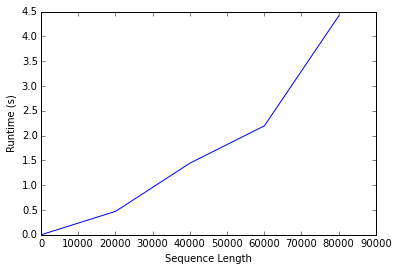

In [51]:
import matplotlib.pyplot as plt

plt.plot(seq_lengths, times)
plt.xlabel('Sequence Length')
plt.ylabel('Runtime (s)')


**One good question is whether developing a version of this algorithm which can run in parallel would be an effective way to make it scale to larger data sets.** In the next cell, we look and how the plot would change if we could run the alignment process over four processors. This would effectively make each alignment run four times as fast (so each runtime would be divided by four) but it doesn't solve our scability problem.

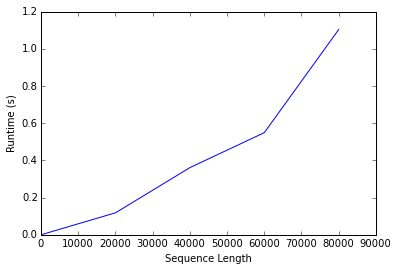

In [52]:
# if we could split this process over more processors (four, for example)
# that would effectively reduce the runtime by 1/4
times = [t / 4 for t in times]


plt.plot(seq_lengths, times)
plt.xlabel('Sequence Length')
plt.ylabel('Runtime (s)')

**Notice that the runtimes in the plot (the y-axis) are smaller, but shape of the curve is the same.** This tells us that we won't be in trouble as soon (we can run bigger alignments in a reasonable amount of time), but we'll still be in trouble eventually. While parallelization can help with this class of computational problem -- one that scales [quadratically](http://en.wikipedia.org/wiki/Quadratic_time) -- it doesn't resolve the problem completely.

How an algorithm scales with input size is referred to as its computational complexity. You can explore the computational complexity of different types of algorithms in the [Big-O cheatsheet](http://bigocheatsheet.com/), though it's a fairly advanced introduction to the topic (and one that's usually covered in the second or third year for Computer Science majors). 

In the next chapter we'll begin exploring ways to address this scalability issue by approximating solutions to the problem.